In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from time import time
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
# 读取文件
# 中远海控 山西汾酒 长城汽车 万泰生物 杭州银行 欧派家居
# 华东医药 泸州老窖 中国中免 福耀玻璃
NAME = "中远海控"
# wtsw = pd.read_excel(r"./allstock.xls",sheet_name= NAME,header=2)

In [3]:
# 文件ETL
wtsw = pd.read_excel(r"./allstocks.xls",sheet_name= NAME,header=0)
wtsw = wtsw.drop(labels=[r"股票代码",r"名称"],axis=1)
wtsw

,日期,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2019-01-02,4.08,4.09,4.02,4.02,4.04,0.04,0.9901,0.1634,12475646,50640170,4.168240e+10,3.115355e+10
1,2019-01-03,4.20,4.22,4.06,4.08,4.08,0.12,2.9412,0.2882,22003741,91620017,4.290835e+10,3.206983e+10
2,2019-01-04,4.29,4.29,4.15,4.17,4.20,0.09,2.1429,0.2413,18426352,78278205,4.382782e+10,3.275704e+10
3,2019-01-07,4.36,4.37,4.27,4.29,4.29,0.07,1.6317,0.3011,22988845,99256869,4.454296e+10,3.329154e+10
4,2019-01-08,4.47,4.58,4.32,4.35,4.36,0.11,2.5229,0.5313,40567284,182584162,4.566675e+10,3.413146e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,2021-05-10,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,2.505848e+11,1.769552e+11
569,2021-05-11,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,2.282724e+11,1.611990e+11
570,2021-05-12,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,2.337892e+11,1.650947e+11
571,2021-05-13,19.01,19.45,18.28,18.40,19.07,-0.06,-0.3146,2.3180,200679351,3792854909,2.330537e+11,1.645753e+11


In [4]:
wtsw = wtsw.dropna()
wtsw = wtsw.reset_index(drop = True)
wtsw

,日期,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2019-01-02,4.08,4.09,4.02,4.02,4.04,0.04,0.9901,0.1634,12475646,50640170,4.168240e+10,3.115355e+10
1,2019-01-03,4.20,4.22,4.06,4.08,4.08,0.12,2.9412,0.2882,22003741,91620017,4.290835e+10,3.206983e+10
2,2019-01-04,4.29,4.29,4.15,4.17,4.20,0.09,2.1429,0.2413,18426352,78278205,4.382782e+10,3.275704e+10
3,2019-01-07,4.36,4.37,4.27,4.29,4.29,0.07,1.6317,0.3011,22988845,99256869,4.454296e+10,3.329154e+10
4,2019-01-08,4.47,4.58,4.32,4.35,4.36,0.11,2.5229,0.5313,40567284,182584162,4.566675e+10,3.413146e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,2021-05-10,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,2.505848e+11,1.769552e+11
569,2021-05-11,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,2.282724e+11,1.611990e+11
570,2021-05-12,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,2.337892e+11,1.650947e+11
571,2021-05-13,19.01,19.45,18.28,18.40,19.07,-0.06,-0.3146,2.3180,200679351,3792854909,2.330537e+11,1.645753e+11


In [5]:
wtsw.loc[wtsw[r"涨跌额"] == '--',r"涨跌额"] = '0'
wtsw[r"涨跌额"] = wtsw[r"涨跌额"].astype("float")
wtsw.loc[wtsw[r"涨跌幅"] == '--',r"涨跌幅"] = '0'
wtsw[r"涨跌幅"] = wtsw[r"涨跌幅"].astype("float")
wtsw.loc[wtsw[r"前收盘"] == '--',r"前收盘"] = '0'
wtsw[r"前收盘"] = wtsw[r"前收盘"].astype("float")
time = wtsw["日期"].apply(lambda x: str(x)).copy()
time = time.apply(lambda x:x[:-9]).astype("string")
time = time.apply(lambda x:x.split('-'))

wtsw["year"] = time.apply(lambda x:x[0])
wtsw["month"] = time.apply(lambda x:x[1])
wtsw["day"] = time.apply(lambda x:x[2])
#time.tolist()
wtsw_dt = wtsw.drop(labels=["日期"],axis=1)
wtsw_dt

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值,year,month,day
0,4.08,4.09,4.02,4.02,4.04,0.04,0.9901,0.1634,12475646,50640170,4.168240e+10,3.115355e+10,2019,01,02
1,4.20,4.22,4.06,4.08,4.08,0.12,2.9412,0.2882,22003741,91620017,4.290835e+10,3.206983e+10,2019,01,03
2,4.29,4.29,4.15,4.17,4.20,0.09,2.1429,0.2413,18426352,78278205,4.382782e+10,3.275704e+10,2019,01,04
3,4.36,4.37,4.27,4.29,4.29,0.07,1.6317,0.3011,22988845,99256869,4.454296e+10,3.329154e+10,2019,01,07
4,4.47,4.58,4.32,4.35,4.36,0.11,2.5229,0.5313,40567284,182584162,4.566675e+10,3.413146e+10,2019,01,08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,2.505848e+11,1.769552e+11,2021,05,10
569,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,2.282724e+11,1.611990e+11,2021,05,11
570,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,2.337892e+11,1.650947e+11,2021,05,12
571,19.01,19.45,18.28,18.40,19.07,-0.06,-0.3146,2.3180,200679351,3792854909,2.330537e+11,1.645753e+11,2021,05,13


In [6]:
wtsw_dt["year"] = wtsw_dt["year"].astype("int")
wtsw_dt["month"] = wtsw_dt["month"].astype("int")
wtsw_dt["day"] = wtsw_dt["day"].astype("int")
# label = wtsw_dt[r"涨跌(元)"][1:wtsw_dt.shape[0]]
label = np.log(wtsw_dt[r"收盘价"]/wtsw_dt[r"前收盘"])[1:wtsw_dt.shape[0]]
label = label.reset_index(drop = True)
wtsw_dtal = wtsw_dt.copy()
wtsw_dtal.drop(index = [len(wtsw_dt)-1],inplace=True)
wtsw_dtal["label"] = label
wtsw_dtal

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值,year,month,day,label
0,4.08,4.09,4.02,4.02,4.04,0.04,0.9901,0.1634,12475646,50640170,4.168240e+10,3.115355e+10,2019,1,2,0.028988
1,4.20,4.22,4.06,4.08,4.08,0.12,2.9412,0.2882,22003741,91620017,4.290835e+10,3.206983e+10,2019,1,3,0.021202
2,4.29,4.29,4.15,4.17,4.20,0.09,2.1429,0.2413,18426352,78278205,4.382782e+10,3.275704e+10,2019,1,4,0.016185
3,4.36,4.37,4.27,4.29,4.29,0.07,1.6317,0.3011,22988845,99256869,4.454296e+10,3.329154e+10,2019,1,7,0.024916
4,4.47,4.58,4.32,4.35,4.36,0.11,2.5229,0.5313,40567284,182584162,4.566675e+10,3.413146e+10,2019,1,8,0.026492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,19.95,21.24,19.48,19.60,19.59,0.36,1.8377,5.0129,433984234,8866304929,2.445776e+11,1.727132e+11,2021,5,7,0.024265
568,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,2.505848e+11,1.769552e+11,2021,5,10,-0.093257
569,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,2.282724e+11,1.611990e+11,2021,5,11,0.023880
570,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,2.337892e+11,1.650947e+11,2021,5,12,-0.003151


In [7]:
# 特征工程
wtsw_fe = wtsw_dtal.copy()
wtsw_fe['range_hl'] = wtsw_fe[r"最高价"] - wtsw_fe[r"最低价"]
wtsw_fe['range_oc'] = wtsw_fe[r"开盘价"] - wtsw_fe[r"收盘价"]

## 把前几天的数据放进来当作当天属性
N = 5
lag_cols = [r'收盘价', 'range_hl', 'range_oc',r'成交量',r'流通市值']
shift_range = [x + 1 for x in range(N)]
for col in lag_cols:
    for i in shift_range:
        new_col='{}_lag_{}'.format(col, i)   # 格式化字符串
        wtsw_fe[new_col]=wtsw_fe[col].shift(i)

wtsw_fe

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,...,成交量_lag_1,成交量_lag_2,成交量_lag_3,成交量_lag_4,成交量_lag_5,流通市值_lag_1,流通市值_lag_2,流通市值_lag_3,流通市值_lag_4,流通市值_lag_5
0,4.08,4.09,4.02,4.02,4.04,0.04,0.9901,0.1634,12475646,50640170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.20,4.22,4.06,4.08,4.08,0.12,2.9412,0.2882,22003741,91620017,...,12475646.0,NaN,NaN,NaN,NaN,3.115355e+10,NaN,NaN,NaN,NaN
2,4.29,4.29,4.15,4.17,4.20,0.09,2.1429,0.2413,18426352,78278205,...,22003741.0,12475646.0,NaN,NaN,NaN,3.206983e+10,3.115355e+10,NaN,NaN,NaN
3,4.36,4.37,4.27,4.29,4.29,0.07,1.6317,0.3011,22988845,99256869,...,18426352.0,22003741.0,12475646.0,NaN,NaN,3.275704e+10,3.206983e+10,3.115355e+10,NaN,NaN
4,4.47,4.58,4.32,4.35,4.36,0.11,2.5229,0.5313,40567284,182584162,...,22988845.0,18426352.0,22003741.0,12475646.0,NaN,3.329154e+10,3.275704e+10,3.206983e+10,3.115355e+10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,19.95,21.24,19.48,19.60,19.59,0.36,1.8377,5.0129,433984234,8866304929,...,361342619.0,244638447.0,301301443.0,217133521.0,300293061.0,1.695965e+11,1.582555e+11,1.590346e+11,1.493385e+11,1.503773e+11
568,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,...,433984234.0,361342619.0,244638447.0,301301443.0,217133521.0,1.727132e+11,1.695965e+11,1.582555e+11,1.590346e+11,1.493385e+11
569,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,...,351294623.0,433984234.0,361342619.0,244638447.0,301301443.0,1.769552e+11,1.727132e+11,1.695965e+11,1.582555e+11,1.590346e+11
570,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,...,348747597.0,351294623.0,433984234.0,361342619.0,244638447.0,1.611990e+11,1.769552e+11,1.727132e+11,1.695965e+11,1.582555e+11


In [27]:
all_data = wtsw_fe[N:]
train = wtsw_fe[N:int(wtsw_fe.shape[0]*0.8)]
test = wtsw_fe[int(wtsw_fe.shape[0]*0.8):]
test.head(10)
# test.columns

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,...,成交量_lag_1,成交量_lag_2,成交量_lag_3,成交量_lag_4,成交量_lag_5,流通市值_lag_1,流通市值_lag_2,流通市值_lag_3,流通市值_lag_4,流通市值_lag_5
457,10.16,10.16,9.16,9.34,9.24,0.92,9.9567,3.0928,267750621,2634353129,...,192946478.0,277615265.0,204293289.0,207181831.0,162095409.0,7.999347e+10,8.051291e+10,7.687684e+10,6.986443e+10,6.735381e+10
458,10.67,10.96,10.18,10.38,10.16,0.51,5.0197,3.5692,308992275,3257509837,...,267750621.0,192946478.0,277615265.0,204293289.0,207181831.0,8.795819e+10,7.999347e+10,8.051291e+10,7.687684e+10,6.986443e+10
459,10.50,10.72,10.28,10.50,10.67,-0.17,-1.5933,2.1565,186695442,1953704425,...,308992275.0,267750621.0,192946478.0,277615265.0,204293289.0,9.237341e+10,8.795819e+10,7.999347e+10,8.051291e+10,7.687684e+10
460,10.19,10.88,9.70,10.65,10.50,-0.31,-2.9524,2.8119,243430526,2489259118,...,186695442.0,308992275.0,267750621.0,192946478.0,277615265.0,9.090167e+10,9.237341e+10,8.795819e+10,7.999347e+10,8.051291e+10
461,10.19,10.32,9.76,10.18,10.19,0.00,0.0000,1.7742,153599440,1541309519,...,243430526.0,186695442.0,308992275.0,267750621.0,192946478.0,8.821791e+10,9.090167e+10,9.237341e+10,8.795819e+10,7.999347e+10
462,10.01,10.19,9.75,10.18,10.19,-0.18,-1.7664,1.4641,126750719,1261127374,...,153599440.0,243430526.0,186695442.0,308992275.0,267750621.0,8.821791e+10,8.821791e+10,9.090167e+10,9.237341e+10,8.795819e+10
463,9.92,10.53,9.56,10.14,10.01,-0.09,-0.8991,2.5853,223816555,2237020268,...,126750719.0,153599440.0,243430526.0,186695442.0,308992275.0,8.665959e+10,8.821791e+10,8.821791e+10,9.090167e+10,9.237341e+10
464,9.69,9.75,9.28,9.72,9.92,-0.23,-2.3185,2.0862,180606045,1722421971,...,223816555.0,126750719.0,153599440.0,243430526.0,186695442.0,8.588043e+10,8.665959e+10,8.821791e+10,8.821791e+10,9.090167e+10
465,9.72,10.03,9.51,9.82,9.69,0.03,0.3096,1.5914,137774632,1346572798,...,180606045.0,223816555.0,126750719.0,153599440.0,243430526.0,8.388925e+10,8.588043e+10,8.665959e+10,8.821791e+10,8.821791e+10
466,9.62,9.96,9.61,9.72,9.72,-0.10,-1.0288,1.2112,104861379,1020399270,...,137774632.0,180606045.0,223816555.0,126750719.0,153599440.0,8.414897e+10,8.388925e+10,8.588043e+10,8.665959e+10,8.821791e+10


In [28]:
all_data_X = all_data.drop(labels=[r"label"],axis=1)
all_data_Y = all_data[r"label"]
train_X = train.drop(labels=[r"label"],axis=1)
train_Y = train[r"label"]
test_X = test.drop(labels=[r"label"],axis=1)
test_Y = test[r"label"]
test_Y.head()

457    0.048978
458   -0.016061
459   -0.029968
460    0.000000
461   -0.017822
Name: label, dtype: float64

In [29]:
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return sum(diff)/sum(true)

In [30]:
my_model = xgb.XGBRegressor(seed=100,
                     n_estimators=100,
                     max_depth=10,
                     eval_metric='rmse',
                     learning_rate=0.1,
                     min_child_weight=1,
                     subsample=0.7,
                     colsample_bytree=1,
                     colsample_bylevel=1,
                     n_jobs = -1,
                     gamma=0)
my_model.fit(train_X,train_Y)
predictions = my_model.predict(test_X)
#print(predictions.tolist())
#print(test_Y)

# 全数据训练 并保存模型
all_data_model = xgb.XGBRegressor(seed=100,
                     n_estimators=100,
                     max_depth=10,
                     eval_metric='rmse',
                     learning_rate=0.1,
                     min_child_weight=1,
                     subsample=0.7,
                     colsample_bytree=1,
                     colsample_bylevel=1,
                     n_jobs = -1,
                     gamma=0)
all_data_model.fit(all_data_X,all_data_Y)
pickle.dump(all_data_model,open(r'./xgb-model/'+NAME+'.pickle.dat',"wb"))

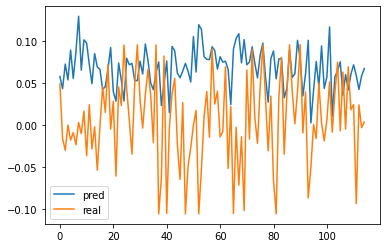

In [31]:
%matplotlib inline
x = [i for i in range(len(test_Y))]
plt.plot(x,predictions,label="pred")
plt.plot(x,test_Y,label="real")
plt.legend()
plt.show()

In [32]:
# 还原成价格(差分还原)
res = test.loc[:,["涨跌额",r"收盘价"]]
res.loc[:,r"res"] = res[r"收盘价"] + predictions
res['res'] = res['res'].shift(1)
res.head()

,涨跌额,收盘价,res
457,0.92,10.16,NaN
458,0.51,10.67,10.217563
459,-0.17,10.50,10.713308
460,-0.31,10.19,10.572417
461,0.00,10.19,10.243621


In [33]:
# 还原成价格（对数收益率还原）
res = test.loc[:,["涨跌额",r"收盘价"]]
res.loc[:,r"res"] = np.exp(predictions)*res[r"收盘价"]
res['res'] = res['res'].shift(1)
res.head(10)

,涨跌额,收盘价,res
457,0.92,10.16,NaN
458,0.51,10.67,10.761998
459,-0.17,10.50,11.142253
460,-0.31,10.19,11.288584
461,0.00,10.19,10.751311
462,-0.18,10.01,11.139127
463,-0.09,9.92,10.578963
464,-0.23,9.69,10.820467
465,0.03,9.72,11.027032
466,-0.10,9.62,10.374037


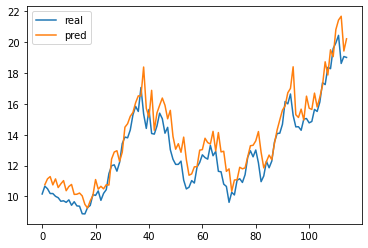

In [34]:
%matplotlib inline
x = [i for i in range(res.shape[0])]
plt.plot(x,res[r"收盘价"],label="real")
plt.plot(x,res[r"res"],label="pred")
plt.legend()
plt.show()

In [35]:
# plotly画图
from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

In [37]:
N = 100
random_x = np.linspace(0,1,N)
random_y0 = np.random.randn(N)+5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N)-5

#Create traces

trace1 = go.Scatter(
    x = x,
    y = res[r"收盘价"],
    mode = 'lines+markers',
    name = "real"
)
trace2 = go.Scatter(
    x = x,
    y = res[r"res"],
    mode = 'lines+markers',
    name = 'pred'
)
data = [trace1,trace2]
py.iplot(data)

In [16]:
'''
parameters={'n_estimators':range(10, 300, 10),
            'max_depth':range(2,10,1),
            'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
            'min_child_weight':range(5, 21, 1),
            # 'subsample':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
            'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
            'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
            'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
            }
#parameters={'max_depth':range(2,10,1)}
model=xgb.XGBRegressor(seed=1,
                    n_estimators=100,
                    max_depth=3,
                    eval_metric='rmse',
                    learning_rate=0.1,
                    min_child_weight=1,
                    subsample=0.7,
                    colsample_bytree=1,
                    colsample_bylevel=1,
                    n_jobs=-1,
                    gamma=0)
gs=GridSearchCV(estimator= model,param_grid=parameters,cv=5,refit= True,scoring='neg_mean_squared_error')

gs.fit(train_X,train_Y)
print('最优参数: ', gs.best_params_)

predictions = gs.predict(test_X)
%matplotlib inline
x = [i for i in range(len(test_Y))]
plt.plot(x,predictions,label="pred")
plt.plot(x,test_Y,label="real")
plt.legend()
plt.show()
'''

'\nparameters={\'n_estimators\':range(10, 300, 10),\n            \'max_depth\':range(2,10,1),\n            \'learning_rate\': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],\n            \'min_child_weight\':range(5, 21, 1),\n            # \'subsample\':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],\n            \'gamma\':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],\n            \'colsample_bytree\':[0.5, 0.6, 0.7, 0.8, 0.9, 1],\n            \'colsample_bylevel\':[0.5, 0.6, 0.7, 0.8, 0.9, 1]\n            }\n#parameters={\'max_depth\':range(2,10,1)}\nmodel=xgb.XGBRegressor(seed=1,\n                    n_estimators=100,\n                    max_depth=3,\n                    eval_metric=\'rmse\',\n                    learning_rate=0.1,\n                    min_child_weight=1,\n                    subsample=0.7,\n                    colsample_bytree=1,\n                    colsample_bylevel=1,\n                    n_jobs=-1,\n                    gamma=0)\ngs=GridSearchCV(estimator= mode

# 开始预测

In [17]:
# 数据准备
wtsw_p = pd.read_excel(r"./prestocks.xls",NAME,header=0)
wtsw_p = wtsw_p.drop(labels=[r"股票代码",r"名称"],axis=1)
wtsw_p = wtsw_p.reset_index(drop = True)
wtsw_p

,日期,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2021-05-07,19.95,21.24,19.48,19.60,19.59,0.36,1.8377,5.0129,433984234,8866304929,244577608079,172713170750
1,2021-05-10,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,250584777400,176955248628
2,2021-05-11,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,228272434207,161198959367
3,2021-05-12,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,233789222359,165094745173
4,2021-05-13,19.01,19.45,18.28,18.40,19.07,-0.06,-0.3146,2.3180,200679351,3792854909,233053650605,164575307066
5,2021-05-14,19.08,19.43,18.71,19.10,19.01,0.07,0.3682,1.9285,166954735,3177007643,233911817651,165181318191
6,2021-05-17,20.99,20.99,19.62,19.62,19.08,1.91,10.0105,3.7495,324602680,6626954533,257327518475,181716764614
7,2021-05-18,22.03,22.47,21.08,21.40,20.99,1.04,4.9547,3.5097,303846179,6630487821,270077428871,190720358478
8,2021-05-19,21.87,22.85,21.60,22.24,22.03,-0.16,-0.7263,3.0150,261018075,5781706308,268115904194,189335190191
9,2021-05-20,20.26,21.82,19.99,21.51,21.87,-1.61,-7.3617,3.9758,344196864,7094481083,248378062139,175396934306


In [18]:
wtsw_p.loc[wtsw_p[r"涨跌额"] == '--',r"涨跌额"] = '0'
wtsw_p[r"涨跌额"] = wtsw_p[r"涨跌额"].astype("float")
wtsw_p.loc[wtsw_p[r"涨跌幅"] == '--',r"涨跌幅"] = '0'
wtsw_p[r"涨跌幅"] = wtsw_p[r"涨跌幅"].astype("float")
wtsw_p.loc[wtsw_p[r"前收盘"] == '--',r"前收盘"] = '0'
wtsw_p[r"前收盘"] = wtsw_p[r"前收盘"].astype("float")
time = wtsw_p["日期"].apply(lambda x: str(x)).copy()
time = time.apply(lambda x:x[:-9]).astype("string")
time = time.apply(lambda x:x.split('-'))

wtsw_p["year"] = time.apply(lambda x:x[0])
wtsw_p["month"] = time.apply(lambda x:x[1])
wtsw_p["day"] = time.apply(lambda x:x[2])
#time.tolist()
wtsw_dt_p = wtsw_p.drop(labels=["日期"],axis=1)
wtsw_dt_p

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值,year,month,day
0,19.95,21.24,19.48,19.60,19.59,0.36,1.8377,5.0129,433984234,8866304929,244577608079,172713170750,2021,05,07
1,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,250584777400,176955248628,2021,05,10
2,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,228272434207,161198959367,2021,05,11
3,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,233789222359,165094745173,2021,05,12
4,19.01,19.45,18.28,18.40,19.07,-0.06,-0.3146,2.3180,200679351,3792854909,233053650605,164575307066,2021,05,13
5,19.08,19.43,18.71,19.10,19.01,0.07,0.3682,1.9285,166954735,3177007643,233911817651,165181318191,2021,05,14
6,20.99,20.99,19.62,19.62,19.08,1.91,10.0105,3.7495,324602680,6626954533,257327518475,181716764614,2021,05,17
7,22.03,22.47,21.08,21.40,20.99,1.04,4.9547,3.5097,303846179,6630487821,270077428871,190720358478,2021,05,18
8,21.87,22.85,21.60,22.24,22.03,-0.16,-0.7263,3.0150,261018075,5781706308,268115904194,189335190191,2021,05,19
9,20.26,21.82,19.99,21.51,21.87,-1.61,-7.3617,3.9758,344196864,7094481083,248378062139,175396934306,2021,05,20


In [19]:
wtsw_dt_p["year"] = wtsw_dt_p["year"].astype("int")
wtsw_dt_p["month"] = wtsw_dt_p["month"].astype("int")
wtsw_dt_p["day"] = wtsw_dt_p["day"].astype("int")
# label = wtsw_dt[r"涨跌(元)"][1:wtsw_dt.shape[0]]
# label = np.log(wtsw_dt_p[r"收盘价"]/wtsw_dt_p[r"前收盘"])[1:wtsw_dt_p.shape[0]]
# label = label.reset_index(drop = True)
wtsw_dtal_p = wtsw_dt_p.copy()
# wtsw_dtal_p.drop(index = [len(wtsw_dt_p)-1],inplace=True)
# wtsw_dtal_p["label"] = label
wtsw_dtal_p

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值,year,month,day
0,19.95,21.24,19.48,19.60,19.59,0.36,1.8377,5.0129,433984234,8866304929,244577608079,172713170750,2021,5,7
1,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,250584777400,176955248628,2021,5,10
2,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,228272434207,161198959367,2021,5,11
3,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,233789222359,165094745173,2021,5,12
4,19.01,19.45,18.28,18.40,19.07,-0.06,-0.3146,2.3180,200679351,3792854909,233053650605,164575307066,2021,5,13
5,19.08,19.43,18.71,19.10,19.01,0.07,0.3682,1.9285,166954735,3177007643,233911817651,165181318191,2021,5,14
6,20.99,20.99,19.62,19.62,19.08,1.91,10.0105,3.7495,324602680,6626954533,257327518475,181716764614,2021,5,17
7,22.03,22.47,21.08,21.40,20.99,1.04,4.9547,3.5097,303846179,6630487821,270077428871,190720358478,2021,5,18
8,21.87,22.85,21.60,22.24,22.03,-0.16,-0.7263,3.0150,261018075,5781706308,268115904194,189335190191,2021,5,19
9,20.26,21.82,19.99,21.51,21.87,-1.61,-7.3617,3.9758,344196864,7094481083,248378062139,175396934306,2021,5,20


In [20]:
# 特征工程
wtsw_fe_p = wtsw_dtal_p.copy()
wtsw_fe_p['range_hl'] = wtsw_fe_p[r"最高价"] - wtsw_fe_p[r"最低价"]
wtsw_fe_p['range_oc'] = wtsw_fe_p[r"开盘价"] - wtsw_fe_p[r"收盘价"]

## 把前几天的数据放进来当作当天属性
N = 5
lag_cols = [r'收盘价', 'range_hl', 'range_oc',r'成交量',r'流通市值']
shift_range = [x + 1 for x in range(N)]
for col in lag_cols:
    for i in shift_range:
        new_col='{}_lag_{}'.format(col, i)   # 格式化字符串
        wtsw_fe_p[new_col]=wtsw_fe_p[col].shift(i)

wtsw_fe_p

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,...,成交量_lag_1,成交量_lag_2,成交量_lag_3,成交量_lag_4,成交量_lag_5,流通市值_lag_1,流通市值_lag_2,流通市值_lag_3,流通市值_lag_4,流通市值_lag_5
0,19.95,21.24,19.48,19.60,19.59,0.36,1.8377,5.0129,433984234,8866304929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20.44,20.70,18.91,20.05,19.95,0.49,2.4561,4.0578,351294623,7010126066,...,433984234.0,NaN,NaN,NaN,NaN,1.727132e+11,NaN,NaN,NaN,NaN
2,18.62,20.15,18.61,20.00,20.44,-1.82,-8.9041,4.0284,348747597,6716546998,...,351294623.0,433984234.0,NaN,NaN,NaN,1.769552e+11,1.727132e+11,NaN,NaN,NaN
3,19.07,19.36,18.40,18.81,18.62,0.45,2.4168,2.9020,251235956,4738574748,...,348747597.0,351294623.0,433984234.0,NaN,NaN,1.611990e+11,1.769552e+11,1.727132e+11,NaN,NaN
4,19.01,19.45,18.28,18.40,19.07,-0.06,-0.3146,2.3180,200679351,3792854909,...,251235956.0,348747597.0,351294623.0,433984234.0,NaN,1.650947e+11,1.611990e+11,1.769552e+11,1.727132e+11,NaN
5,19.08,19.43,18.71,19.10,19.01,0.07,0.3682,1.9285,166954735,3177007643,...,200679351.0,251235956.0,348747597.0,351294623.0,433984234.0,1.645753e+11,1.650947e+11,1.611990e+11,1.769552e+11,1.727132e+11
6,20.99,20.99,19.62,19.62,19.08,1.91,10.0105,3.7495,324602680,6626954533,...,166954735.0,200679351.0,251235956.0,348747597.0,351294623.0,1.651813e+11,1.645753e+11,1.650947e+11,1.611990e+11,1.769552e+11
7,22.03,22.47,21.08,21.40,20.99,1.04,4.9547,3.5097,303846179,6630487821,...,324602680.0,166954735.0,200679351.0,251235956.0,348747597.0,1.817168e+11,1.651813e+11,1.645753e+11,1.650947e+11,1.611990e+11
8,21.87,22.85,21.60,22.24,22.03,-0.16,-0.7263,3.0150,261018075,5781706308,...,303846179.0,324602680.0,166954735.0,200679351.0,251235956.0,1.907204e+11,1.817168e+11,1.651813e+11,1.645753e+11,1.650947e+11
9,20.26,21.82,19.99,21.51,21.87,-1.61,-7.3617,3.9758,344196864,7094481083,...,261018075.0,303846179.0,324602680.0,166954735.0,200679351.0,1.893352e+11,1.907204e+11,1.817168e+11,1.651813e+11,1.645753e+11


In [21]:
all_data_p = wtsw_fe_p[N:]
all_data_p

,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,...,成交量_lag_1,成交量_lag_2,成交量_lag_3,成交量_lag_4,成交量_lag_5,流通市值_lag_1,流通市值_lag_2,流通市值_lag_3,流通市值_lag_4,流通市值_lag_5
5,19.08,19.43,18.71,19.10,19.01,0.07,0.3682,1.9285,166954735,3177007643,...,200679351.0,251235956.0,348747597.0,351294623.0,433984234.0,1.645753e+11,1.650947e+11,1.611990e+11,1.769552e+11,1.727132e+11
6,20.99,20.99,19.62,19.62,19.08,1.91,10.0105,3.7495,324602680,6626954533,...,166954735.0,200679351.0,251235956.0,348747597.0,351294623.0,1.651813e+11,1.645753e+11,1.650947e+11,1.611990e+11,1.769552e+11
7,22.03,22.47,21.08,21.40,20.99,1.04,4.9547,3.5097,303846179,6630487821,...,324602680.0,166954735.0,200679351.0,251235956.0,348747597.0,1.817168e+11,1.651813e+11,1.645753e+11,1.650947e+11,1.611990e+11
8,21.87,22.85,21.60,22.24,22.03,-0.16,-0.7263,3.0150,261018075,5781706308,...,303846179.0,324602680.0,166954735.0,200679351.0,251235956.0,1.907204e+11,1.817168e+11,1.651813e+11,1.645753e+11,1.650947e+11
9,20.26,21.82,19.99,21.51,21.87,-1.61,-7.3617,3.9758,344196864,7094481083,...,261018075.0,303846179.0,324602680.0,166954735.0,200679351.0,1.893352e+11,1.907204e+11,1.817168e+11,1.651813e+11,1.645753e+11
10,22.29,22.29,20.35,20.65,20.26,2.03,10.0197,3.8601,334179212,7179067176,...,344196864.0,261018075.0,303846179.0,324602680.0,166954735.0,1.753969e+11,1.893352e+11,1.907204e+11,1.817168e+11,1.651813e+11
11,21.37,22.65,20.80,22.59,22.29,-0.92,-4.1274,3.6328,314505755,6748226717,...,334179212.0,344196864.0,261018075.0,303846179.0,324602680.0,1.929713e+11,1.753969e+11,1.893352e+11,1.907204e+11,1.817168e+11
12,21.20,21.36,20.20,21.20,21.37,-0.17,-0.7955,2.8131,243538479,5071151510,...,314505755.0,334179212.0,344196864.0,261018075.0,303846179.0,1.850065e+11,1.929713e+11,1.753969e+11,1.893352e+11,1.907204e+11
13,20.68,20.96,20.00,20.70,21.20,-0.52,-2.4528,3.0374,262953543,5383867367,...,243538479.0,314505755.0,334179212.0,344196864.0,261018075.0,1.835348e+11,1.850065e+11,1.929713e+11,1.753969e+11,1.893352e+11
14,20.96,21.56,20.40,20.50,20.68,0.28,1.3540,2.3085,199854402,4206503386,...,262953543.0,243538479.0,314505755.0,334179212.0,344196864.0,1.790330e+11,1.835348e+11,1.850065e+11,1.929713e+11,1.753969e+11


In [22]:
# 模型读取
model_name = r'./xgb-model/'+NAME+'.pickle.dat'
model = pickle.load(open(model_name,'rb'))

In [23]:
# 预测输出
predictions = model.predict(all_data_p)
predictions

array([ 0.03709006,  0.00947789, -0.00685793,  0.02429945,  0.06272816,
        0.00861384,  0.0266267 ,  0.05302341,  0.06267132,  0.03049128,
        0.01610411,  0.07194556, -0.00707351, -0.02476415,  0.05500073,
        0.03951749], dtype=float32)

In [24]:
# 还原成价格（对数收益率还原）
res = all_data_p.loc[:,['year','month','day',"涨跌额",r"收盘价"]]
res.loc[:,r"预测的收盘价"] = np.exp(predictions)*res[r"收盘价"]
res['预测的收盘价'] = res['预测的收盘价'].shift(1)
res = res.reset_index(drop = True)
res = res.drop(index=[0])
res

,year,month,day,涨跌额,收盘价,预测的收盘价
1,2021,5,17,1.91,20.99,19.800966
2,2021,5,18,1.04,22.03,21.189886
3,2021,5,19,-0.16,21.87,21.879436
4,2021,5,20,-1.61,20.26,22.407940
5,2021,5,21,2.03,22.29,21.571578
6,2021,5,24,-0.92,21.37,22.482831
7,2021,5,25,-0.17,21.20,21.946655
8,2021,5,26,-0.52,20.68,22.354432
9,2021,5,27,0.28,20.96,22.017518
10,2021,5,28,0.71,21.67,21.608941


In [25]:
# 写入文件保存
res.to_excel(f'{NAME}-outputs.xls',sheet_name=NAME,index=False)